# 0. 라이브러리 불러오기

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score 
from sklearn.metrics import confusion_matrix, classification_report

import xgboost
from xgboost import XGBClassifier

from itertools import chain

In [2]:
print("library version check")
print("numpy: ", np.__version__)
print("pandas: ", pd.__version__)
print("seaborn: ", sns.__version__)
print("matplotlib: ", mpl.__version__)
print("sklearn: ", sklearn.__version__)
print("xgboost", xgboost.__version__)

library version check
numpy:  1.23.5
pandas:  1.5.1
seaborn:  0.12.1
matplotlib:  3.6.2
sklearn:  1.1.3
xgboost 2.0.3


In [3]:
matplotlib_inline.backend_inline.set_matplotlib_formats("png2x")
mpl.style.use("default")
#mpl.rcParams.update({"figure.constrained_layout.use": True})

sns.set_context("paper") 
sns.set_palette("Set2") 
sns.set_style("whitegrid") 

plt.rc("font", family = "Malgun Gothic")
plt.rcParams["axes.unicode_minus"] = False

# 1. 데이터 불러오기

In [4]:
train = pd.read_csv("../data/train.csv", 
                 encoding="utf-8", 
                 index_col=0).astype({"Survived": "category",
                                      "Pclass": "category",
                                      "Sex": "category"})

test = pd.read_csv("../data/test.csv", 
                 encoding="utf-8",
                  index_col = 0).astype({"Pclass": "category",
                                         "Sex": "category"})

label = pd.read_csv("../data/gender_submission.csv",
                    encoding="utf-8",
                    index_col = 0)

In [5]:
# Age, Cabin에 결측
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Survived  891 non-null    category
 1   Pclass    891 non-null    category
 2   Name      891 non-null    object  
 3   Sex       891 non-null    category
 4   Age       714 non-null    float64 
 5   SibSp     891 non-null    int64   
 6   Parch     891 non-null    int64   
 7   Ticket    891 non-null    object  
 8   Fare      891 non-null    float64 
 9   Cabin     204 non-null    object  
 10  Embarked  889 non-null    object  
dtypes: category(3), float64(2), int64(2), object(4)
memory usage: 65.6+ KB


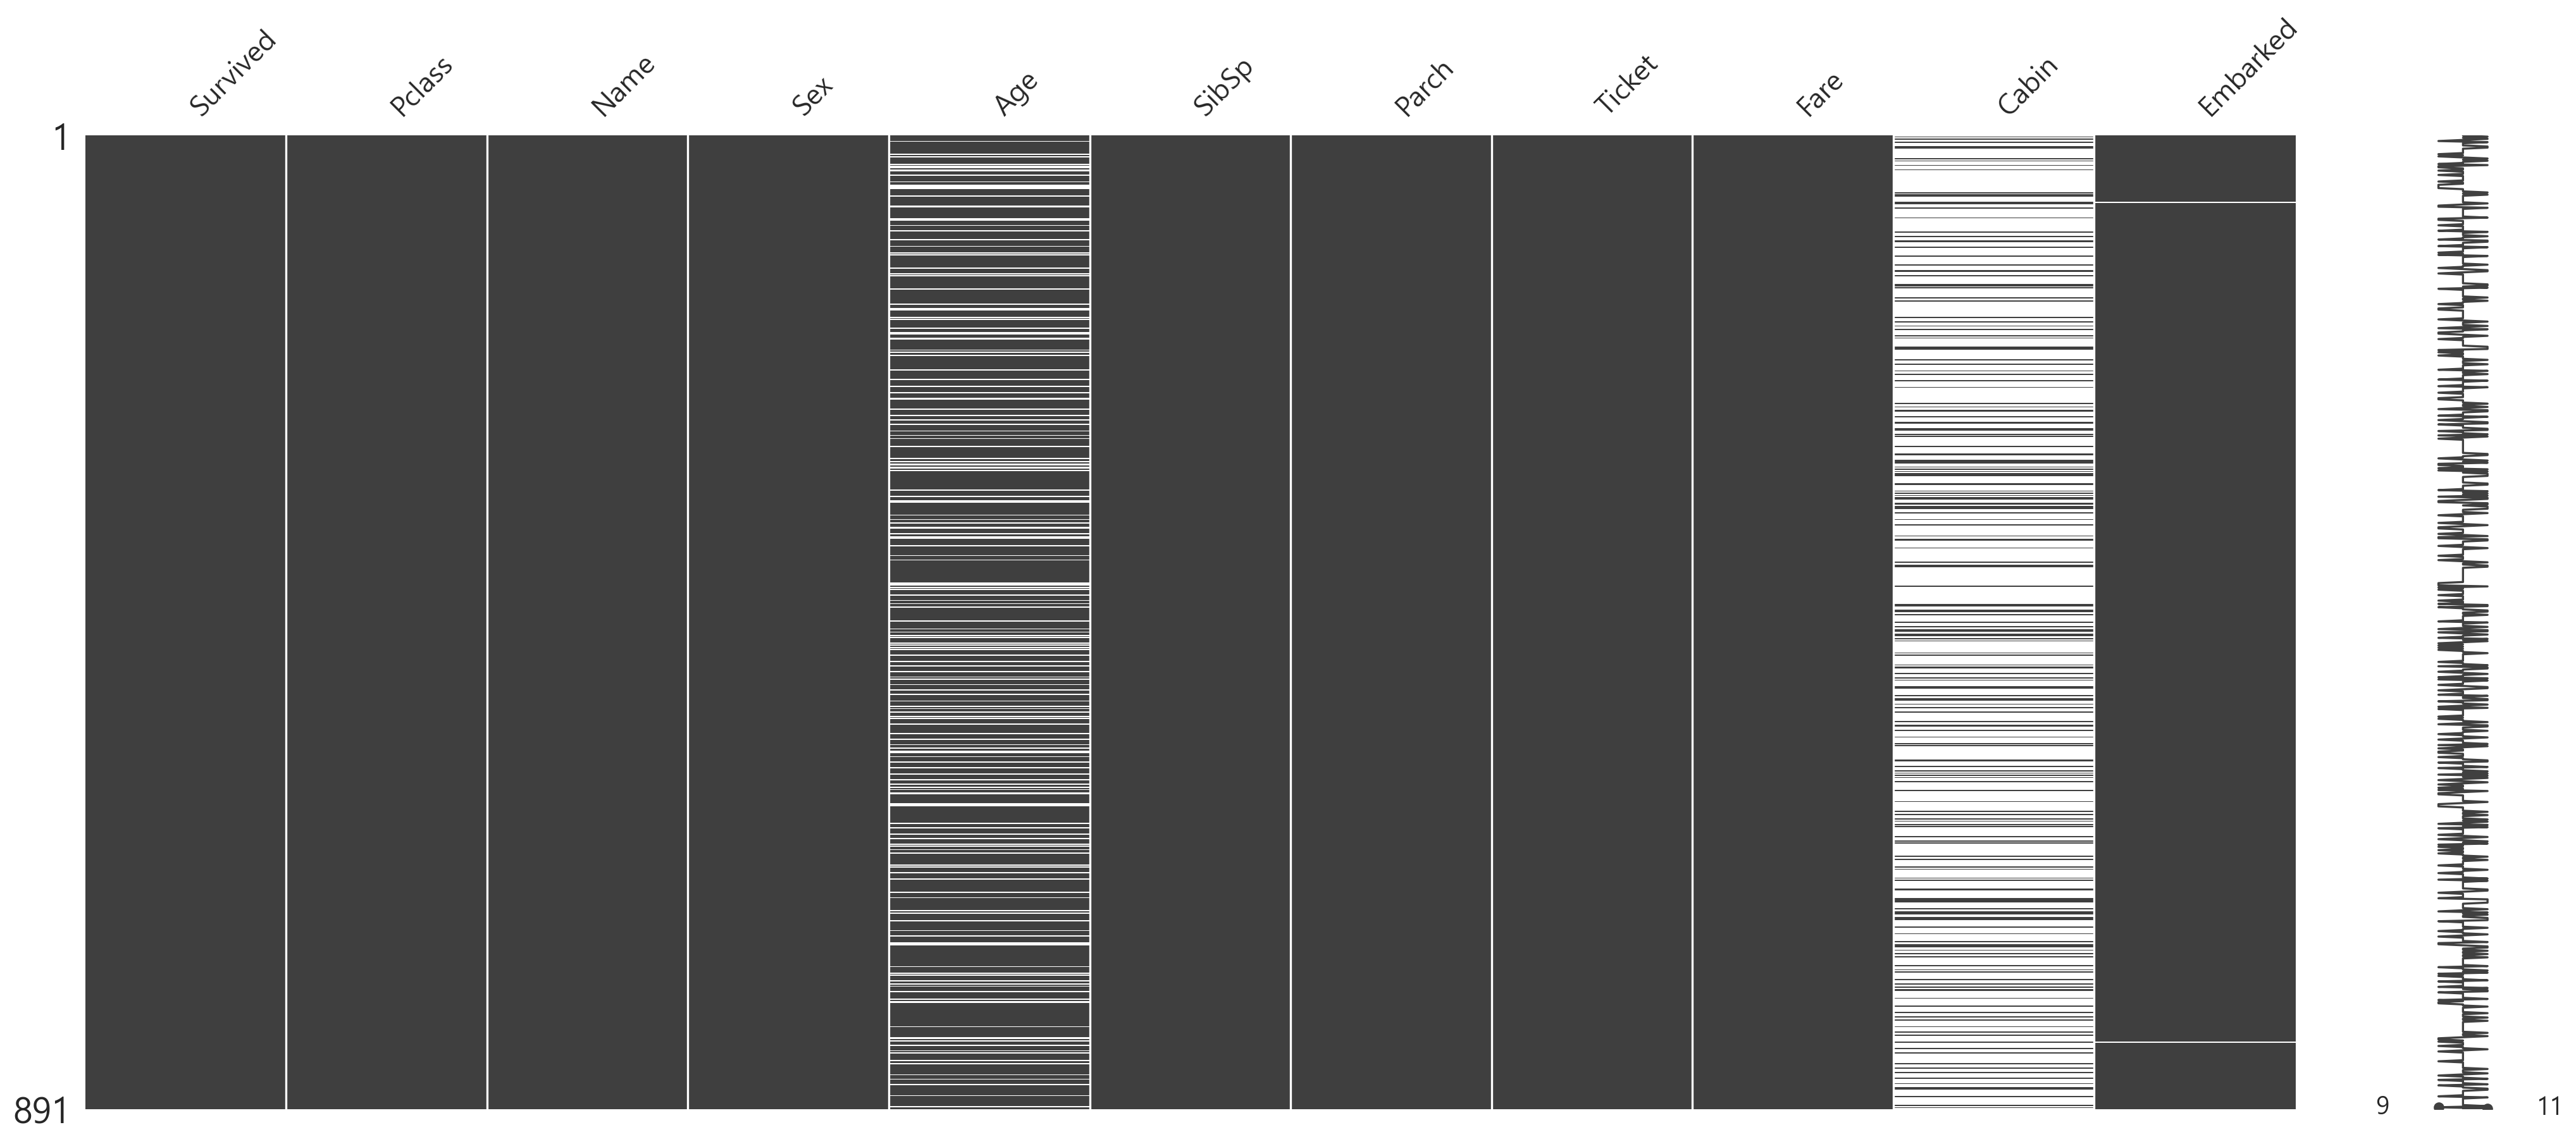

In [6]:
# 결측값을 시각화 하기
msno.matrix(train);

In [7]:
# Age, Fare, Cabin에 결측
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Pclass    418 non-null    category
 1   Name      418 non-null    object  
 2   Sex       418 non-null    category
 3   Age       332 non-null    float64 
 4   SibSp     418 non-null    int64   
 5   Parch     418 non-null    int64   
 6   Ticket    418 non-null    object  
 7   Fare      417 non-null    float64 
 8   Cabin     91 non-null     object  
 9   Embarked  418 non-null    object  
dtypes: category(2), float64(2), int64(2), object(4)
memory usage: 30.5+ KB


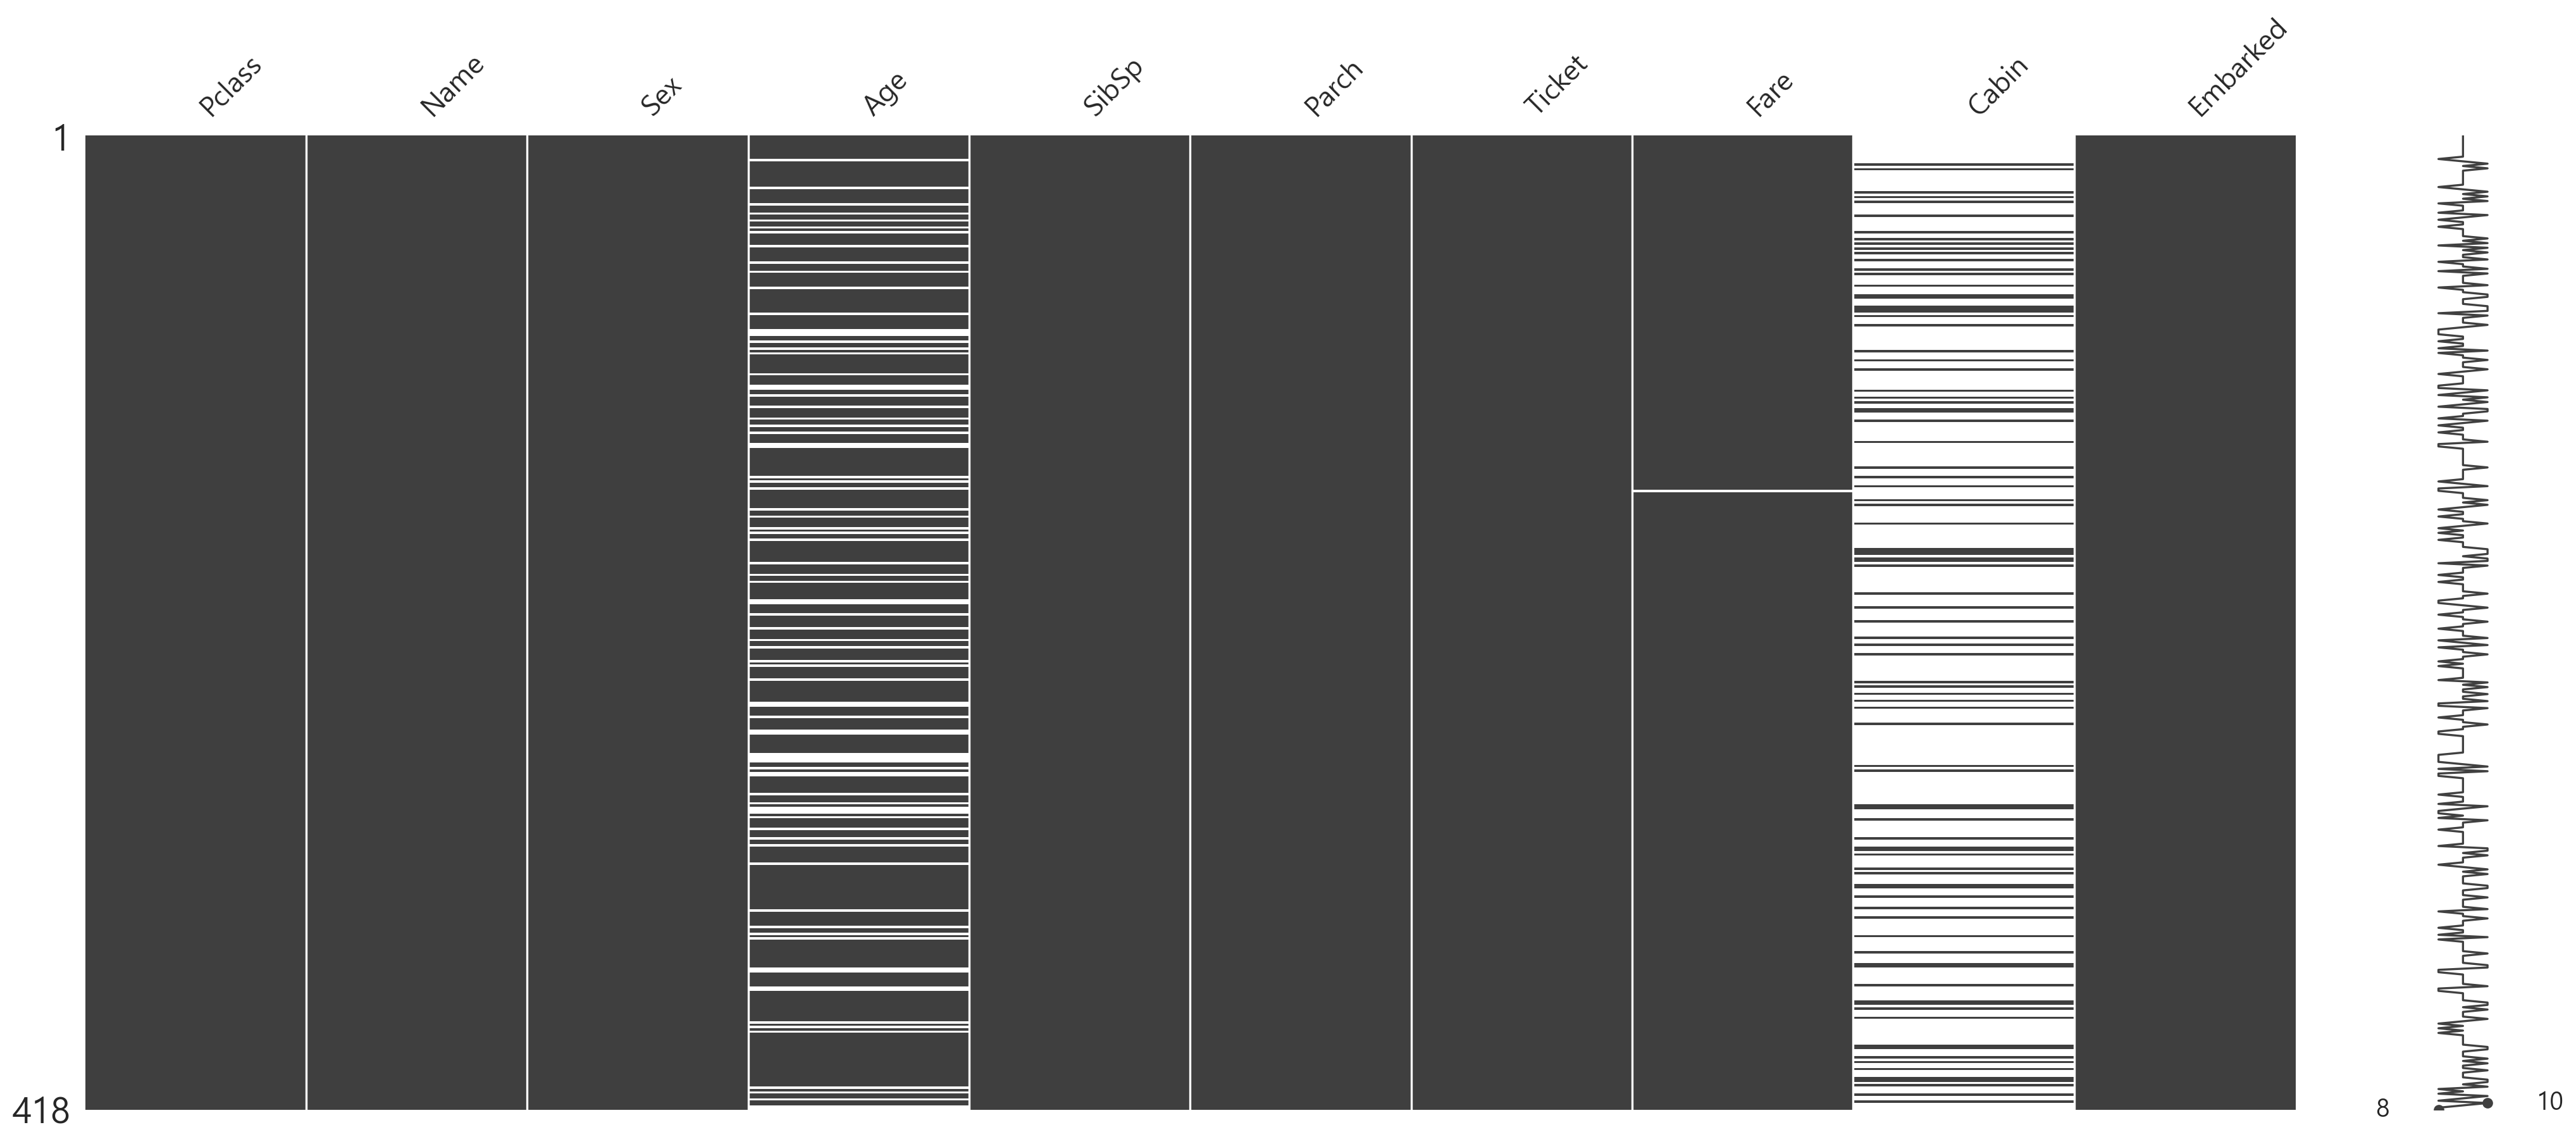

In [8]:
msno.matrix(test);

# 2. 전처리

## 2.1 결측

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Survived  891 non-null    category
 1   Pclass    891 non-null    category
 2   Name      891 non-null    object  
 3   Sex       891 non-null    category
 4   Age       714 non-null    float64 
 5   SibSp     891 non-null    int64   
 6   Parch     891 non-null    int64   
 7   Ticket    891 non-null    object  
 8   Fare      891 non-null    float64 
 9   Cabin     204 non-null    object  
 10  Embarked  889 non-null    object  
dtypes: category(3), float64(2), int64(2), object(4)
memory usage: 65.6+ KB


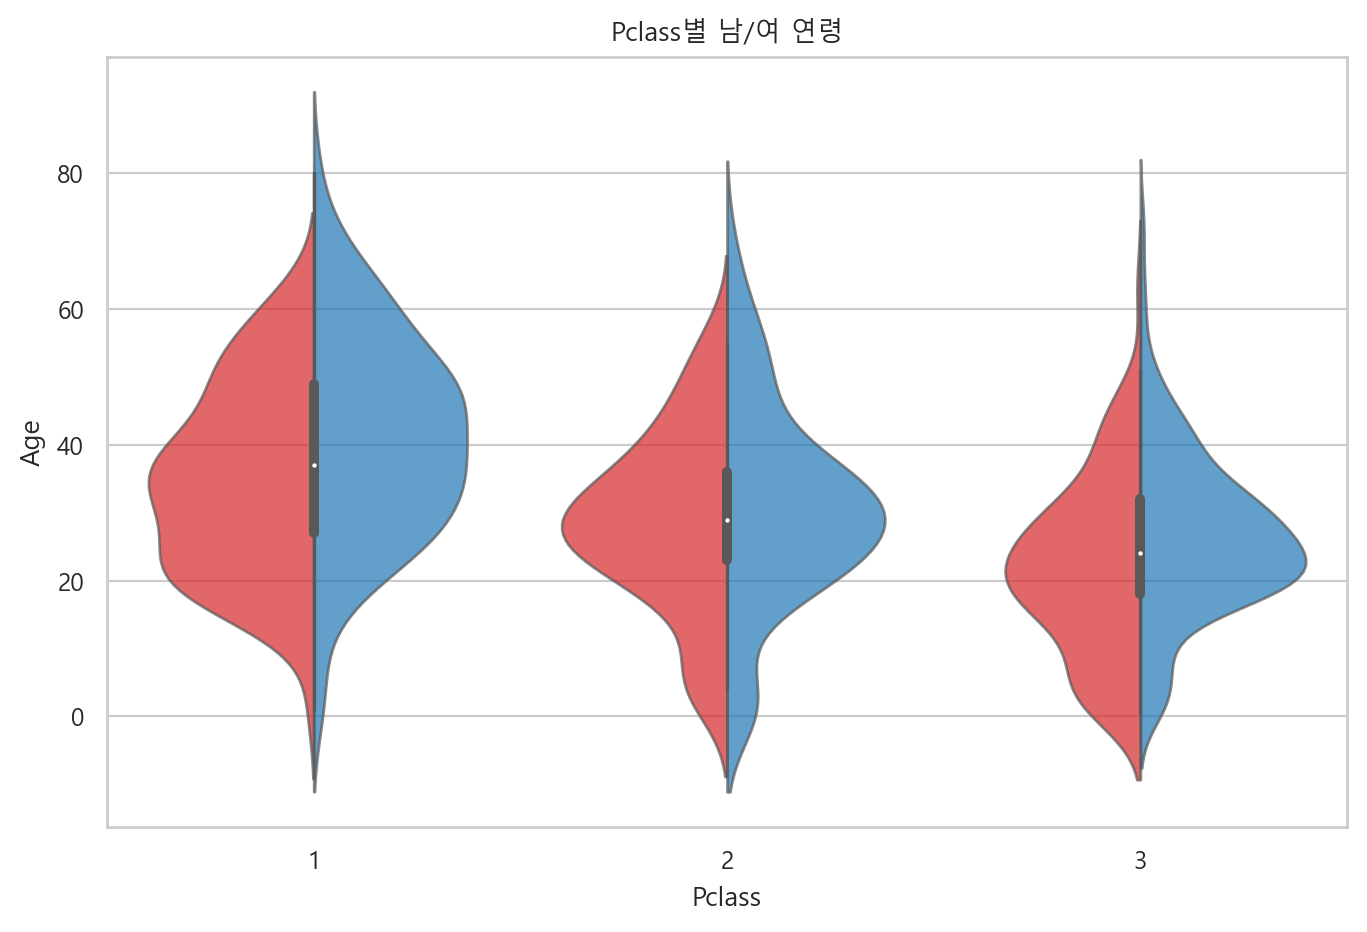

In [11]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.violinplot(data = train,
               x = "Pclass",
               y = "Age",
               hue = "Sex",
               split = True,
               ax = ax)

# 남성: tab:blue, 여성: tab:red
for i, obj in enumerate(ax.collections):
    if i in [0, 3, 6]:
        obj.set_fc("tab:red")
        obj.set_lw(1)
        obj.set_alpha(0.7)
    elif i in [2, 5, 8]: 
        obj.set_fc("tab:blue")
        obj.set_lw(1)
        obj.set_alpha(0.7)

ax.get_legend().remove()
ax.set_title("Pclass별 남/여 연령");

In [12]:
train.groupby(['Pclass', 'Sex'])['Age'].agg('mean')

Pclass  Sex   
1       female    34.611765
        male      41.281386
2       female    28.722973
        male      30.740707
3       female    21.750000
        male      26.507589
Name: Age, dtype: float64

* Pclass, Sex로 Age를 채워보자. 

**train**

* 결측: Age

In [13]:
age_index = []
age_values = []

for c in [1, 2, 3]:
    for s in ["female", "male"]:
        age = train[(train["Pclass"] == c) & (train["Sex"] == s)]["Age"].mean()
        age_fill = train[(train["Pclass"] == c) & (train["Sex"] == s)]["Age"].fillna(age)
        age_index.append(age_fill.keys().to_numpy())
        age_values.append(age_fill.values)

In [15]:
# train 결측 index
age_index_1d = list(chain.from_iterable(age_index))
# train 등급, 성별을 반영한 연령 평균
age_values_1d = list(chain.from_iterable(age_values))

In [16]:
df_age = pd.DataFrame(data = age_values_1d, 
                      index = age_index_1d, 
                      columns = ["new_age"])

In [18]:
train_new_age = pd.merge(train, df_age, left_index=True, right_index=True)
train_new_age

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,new_age
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,22.00
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,38.00
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,26.00
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,35.00
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,35.00
...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,27.00
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,19.00
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,21.75
890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,26.00


**test**

* 주의: 테스트 데이터의 결측은 train의 대표값으로 채워야 한다.

* 결측: Age, Fare

In [19]:
age_index = []
age_values = []

for c in [1, 2, 3]:
    for s in ["female", "male"]:
        age = train[(train["Pclass"] == c) & (train["Sex"] == s)]["Age"].mean()
        age_fill = test[(test["Pclass"] == c) & (test["Sex"] == s)]["Age"].fillna(age)
        age_index.append(age_fill.keys().to_numpy())
        age_values.append(age_fill.values)

In [20]:
age_index_1d = list(chain.from_iterable(age_index))
age_values_1d = list(chain.from_iterable(age_values))

In [21]:
df_age = pd.DataFrame(data = age_values_1d, index = age_index_1d, columns = ["new_age"])

In [22]:
test_new_age = pd.merge(test, df_age, left_index=True, right_index=True)

In [23]:
#Fare
test_new_age["Fare"].fillna(train_new_age["Fare"].mean(), inplace=True)

**Age를 잘 채운걸까?**

In [24]:
train_copy = train.copy()
train_copy["Age"].fillna(train["Age"].mean(), inplace=True)

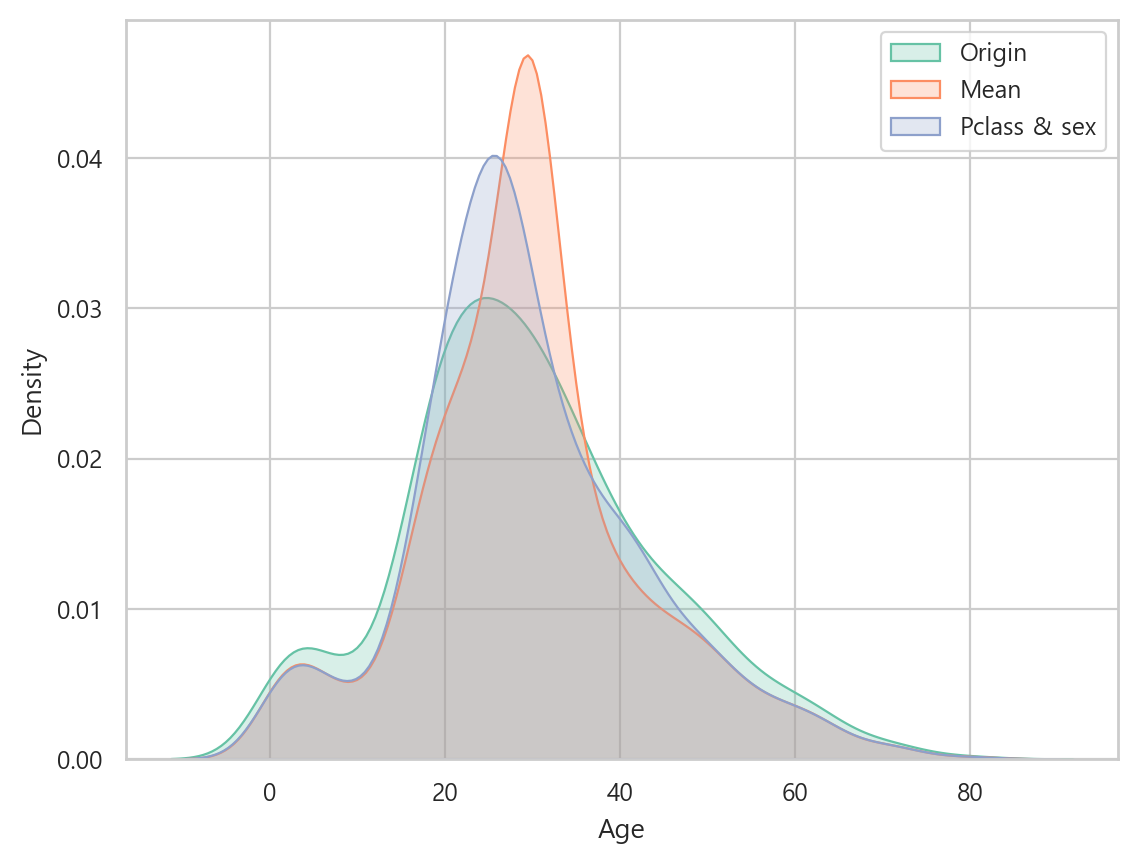

In [25]:
fig, ax = plt.subplots()

sns.kdeplot(train["Age"], 
            fill= True,
            label = "Origin")

sns.kdeplot(train_copy["Age"], 
            fill= True,
            label = "Mean")

sns.kdeplot(train_new_age["new_age"], 
            fill= True,
            label = "Pclass & sex");

ax.legend();

## 2.2 feature selection & One-hot Encoding

In [26]:
# feature selection
col = ["Pclass", "Sex", "new_age", "Fare"]

In [27]:
# 대소문자 주의
X_train = train_new_age[col]
X_test = test_new_age[col]
y_train = train_new_age["Survived"].values
y_test = label["Survived"].values

In [29]:
X_train.head(2)

,Pclass,Sex,new_age,Fare
1,3,male,22.0,7.2500
2,1,female,38.0,71.2833


In [30]:
x_train = X_train[["new_age", "Fare"]].merge(
                                            pd.get_dummies(X_train[["Pclass", "Sex"]], 
                                            drop_first=True),left_index=True, right_index=True
                                            )

In [31]:
x_test = X_test[["new_age", "Fare"]].merge(
                                            pd.get_dummies(X_test[["Pclass", "Sex"]], 
                                            drop_first=True),left_index=True, right_index=True
                                            )

In [32]:
x_train.head(2)

,new_age,Fare,Pclass_2,Pclass_3,Sex_male
1,22.0,7.2500,0,1,1
2,38.0,71.2833,0,0,0


# 3. model

In [33]:
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_test: ", x_test.shape)
print("y_test: ", y_test.shape)

x_train:  (891, 5)
y_train:  (891,)
x_test:  (418, 5)
y_test:  (418,)


## 3.1 DT

In [34]:
tree = DecisionTreeClassifier(random_state = 209, max_depth = 5)
tree.fit(x_train, y_train)
pred_tree = tree.predict(x_test)
accuracy_score(pred_tree, y_test)

0.930622009569378

## 3.2 RFC

In [35]:
rfc = RandomForestClassifier(random_state=209, max_depth = 3)
rfc.fit(x_train, y_train)
pred_rfc = rfc.predict(x_test)
accuracy_score(pred_rfc, y_test)

0.937799043062201

## 3.3 XGBoost

In [36]:
xgb= XGBClassifier(booster = "gbtree", 
                   objective = "binary:logistic")
xgb.fit(x_train, y_train)
pred_xgb = xgb.predict(x_test)
accuracy_score(pred_xgb, y_test)

0.8325358851674641

# 4. AUC-ROC Curve

In [45]:
xgb.predict_proba(x_test)[0,1]

False

In [49]:
thr = 0.9
pred_thr = xgb.predict_proba(x_test)[:,1]>thr

tn = len([i for i in range(len(y_test)) if (y_test[i] == 0) and (pred_thr[i] == 0)])
fp = len([i for i in range(len(y_test)) if (y_test[i] == 0) and (pred_thr[i] == 1)])
fn = len([i for i in range(len(y_test)) if (y_test[i] == 1) and (pred_thr[i] == 0)])
tp = len([i for i in range(len(y_test)) if (y_test[i] == 1) and (pred_thr[i] == 1)])
    
print("TPR: ", tp/(fn+tp))
print("FPR: ", fp/(tn+fp))

TPR:  0.506578947368421
FPR:  0.03383458646616541


In [50]:
tree_fpr, tree_tpr, tree_thr = roc_curve(y_test, tree.predict_proba(x_test)[:,1])
rfc_fpr, rfc_tpr, rfc_thr = roc_curve(y_test, rfc.predict_proba(x_test)[:,1])
xgb_fpr, xgb_tpr, xgb_thr = roc_curve(y_test, xgb.predict_proba(x_test)[:,1])

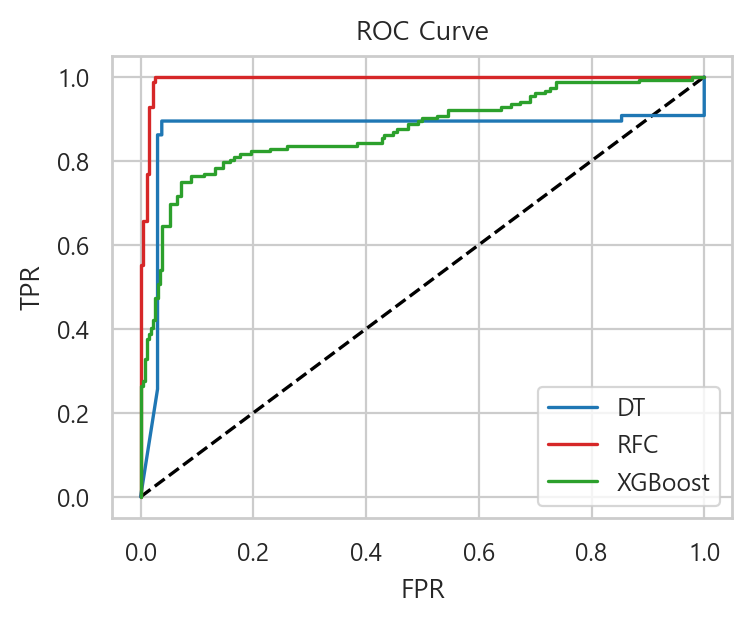

In [53]:
fig, ax = plt.subplots(figsize=(4,3))
ax.plot([0,1], [0,1], "k--")
ax.plot(tree_fpr, tree_tpr, label="DT", color = "tab:blue")
ax.plot(rfc_fpr, rfc_tpr, label="RFC", color = "tab:red")
ax.plot(xgb_fpr, xgb_tpr, label="XGBoost", color = "tab:green")

ax.set(xlabel="FPR", ylabel="TPR", title = "ROC Curve")
ax.legend();

In [54]:
accuracy_score(pred_rfc, y_test)

0.937799043062201

In [55]:
accuracy_score(pred_tree, y_test)

0.930622009569378

In [56]:
print("AUC score of DT:", roc_auc_score(y_test, tree.predict_proba(x_test)[:,1]))
print("AUC score of RFC:", roc_auc_score(y_test, rfc.predict_proba(x_test)[:,1]))
print("AUC score of XGBoost:", roc_auc_score(y_test, xgb.predict_proba(x_test)[:,1]))

AUC score of DT: 0.8733676296003167
AUC score of RFC: 0.994286703601108
AUC score of XGBoost: 0.8725019786307875
